In [1]:
import sys

In [2]:
import numpy as np
import scipy.stats
import xarray as xr

In [3]:
sys.path.append('../src/lib/')
import plot

In [4]:
sfa = xr.open_dataset('../models/sfa.nc')
sfa

<xarray.Dataset>
Dimensions:  (factor: 10, patient: 304)
Coordinates:
  * factor   (factor) object 'Factor 1' 'Factor 2' 'Factor 3' 'Factor 4' ...
  * patient  (patient) int64 1237 976 1382 480 1016 630 636 859 196 367 1861 ...
Data variables:
    factors  (factor, patient) float64 -0.2269 1.02 -0.4513 -0.1683 -0.7058 ...

In [5]:
mri = xr.open_dataset('../data/processed/mri-features.nc')
mri

<xarray.Dataset>
Dimensions:                              (patient: 304)
Coordinates:
  * patient                              (patient) int64 192 196 199 204 207 ...
Data variables:
    Comment                              (patient) object '' '' '' ...
    MultiFocal                           (patient) float64 0.0 0.0 0.0 0.0 ...
    circularity                          (patient) float64 0.8344 0.7081 ...
    irregularity                         (patient) float64 0.4046 0.5653 ...
    volume                               (patient) float64 784.6 1.351e+04 ...
    largest_diameter                     (patient) float64 15.07 44.05 29.68 ...
    mean_vox_val                         (patient) float64 109.0 67.0 64.0 ...
    variance_vox_val                     (patient) float64 1.364e+03 502.0 ...
    uptake_speed                         (patient) float64 0.9821 1.802 ...
    washout                              (patient) float64 0.1572 0.162 ...
    ser                                  (p

In [6]:
assert all(mri['patient'] == sfa['patient'])

In [7]:
mri_features = list(set(mri.keys()) - {'patient', 'Comment', 'MultiFocal'})
factor_feature_cor = xr.DataArray(
    np.full((sfa['factor'].shape[0], len(mri_features)), np.nan),
    dims=['factor', 'mri_feature'],
    coords={
        'factor': sfa['factor'],
        'mri_feature': mri_features,
    },
)
factor_feature_cor_nom_p = factor_feature_cor.copy()

for feature in factor_feature_cor['mri_feature']:
    feature = feature.item()
    for factor in factor_feature_cor['factor']:
        factor = factor.item()
        mri_v = mri[feature].values
        factor_v = sfa['factors'].loc[{'factor': factor}].values
        
        not_nan = np.logical_not(np.isnan(factor_v) | np.isnan(mri_v))
        c, p = scipy.stats.pearsonr(mri_v[not_nan], factor_v[not_nan])
        
        factor_feature_cor.loc[{'factor': factor, 'mri_feature': feature}] = c
        factor_feature_cor_nom_p.loc[{'factor': factor, 'mri_feature': feature}] = p
        
factor_feature_cor_p = np.fmax(
    factor_feature_cor_nom_p *
    factor_feature_cor_nom_p.shape[0] *
    factor_feature_cor_nom_p.shape[0],
    1.0)

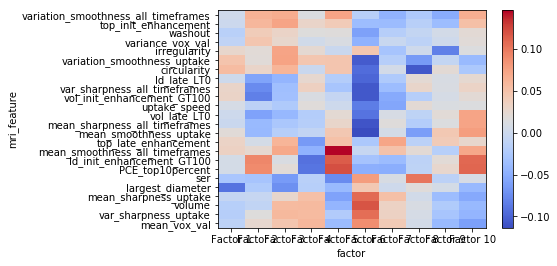

In [8]:
plot.heatmap(factor_feature_cor.T, cmap='coolwarm', row_dendrogram=True)

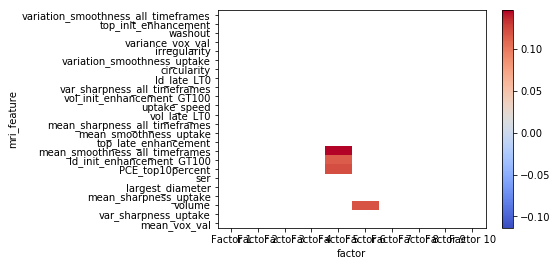

In [9]:
plot.heatmap(factor_feature_cor.T, mask=factor_feature_cor_nom_p.T > 0.05, cmap='coolwarm', row_dendrogram=True)

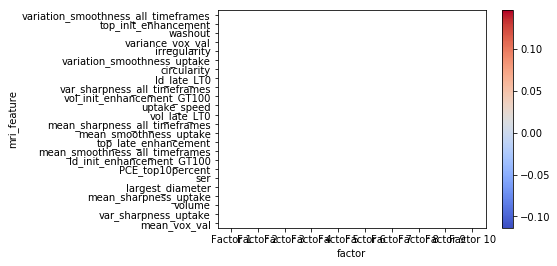

In [10]:
plot.heatmap(factor_feature_cor.T, mask=factor_feature_cor_p.T > 0.25, cmap='coolwarm', row_dendrogram=True)